# Feed-Forward Neural Network
This notebook uses a basic (feed-forward) artificial network to predict presence/absence of beetles in raster cells.

In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
import time
from keras.callbacks import EarlyStopping, ModelCheckpoint 
from keras.layers import Activation, BatchNormalization, Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from pprint import pprint
from pylab import *
from sklearn.metrics import auc, confusion_matrix, roc_auc_score, roc_curve 
from sklearn.preprocessing import StandardScaler

sys.path.append('../')
import data_manipulations as manip

%matplotlib inline

plt.rcParams['figure.figsize'] = 10, 8
plt.style.use('ggplot')

Using TensorFlow backend.


In [2]:
DATA_PATH =  '../../data/cluster/random/'
os.listdir(DATA_PATH)

['weights.bestNN.hdf5',
 'X_test.csv',
 'X_train.csv',
 'X_train.csv.zip',
 'X_valid.csv',
 'y_test.csv',
 'y_train.csv',
 'y_valid.csv']

In [3]:
def load_data(data_dir):
    X_train = pd.read_csv(data_dir + 'X_train.csv')
    print('X_train:', X_train.shape)
    X_valid = pd.read_csv(data_dir + 'X_valid.csv')
    print('X_valid:', X_valid.shape)
    X_test  = pd.read_csv(data_dir + 'X_test.csv')
    print('X_test:',  X_test.shape)
    y_train = pd.read_csv(data_dir + 'y_train.csv')
    print('y_train:', y_train.shape)
    y_valid = pd.read_csv(data_dir + 'y_valid.csv')
    print('y_valid:', y_valid.shape)
    y_test  = pd.read_csv(data_dir + 'y_test.csv')
    print('y_test:',  y_test.shape)
    
    return [[X_train, y_train], [X_valid, y_valid], [X_test, y_test]]

In [4]:
[[X_train, y_train], [X_valid, y_valid], [X_test, y_test]] = load_data(
    DATA_PATH)

X_train: (617893, 24)
X_valid: (132406, 24)
X_test: (132406, 24)
y_train: (617893, 1)
y_valid: (132406, 1)
y_test: (132406, 1)


In [5]:
list(X_train)

['year',
 'meanTemp_Annual',
 'meanTemp_AprAug',
 'meanTemp_Aug',
 'meanMinTemp_DecFeb',
 'meanMinTemp_Oct',
 'meanMinTemp_Jan',
 'meanMinTemp_Mar',
 'meanMaxTemp_Aug',
 'precip_meanAnnual',
 'precip_JunAug',
 'vegetation',
 'precipPrevious_JunAug',
 'precip_OctSep',
 'precipPrevious_OctSep',
 'precip_growingSeason',
 'varPrecip_growingSeason',
 'elev_etopo1',
 'lat',
 'lon',
 'studyArea',
 'elev_srtm30',
 'x',
 'y']

In [6]:
def summarize(df, field, plot=True):
    quantiles = df.quantile(q=[0, 0.25, 0.5, 0.75, 1], axis=0)
    means = df.mean(axis=0)
    
    quants = quantiles[field]
    values = df[field]
    values = values[np.isnan(values) == False]
    n_nan  = values[np.isnan(values) == True].sum()
    is_finite = np.isfinite(values).all()

    print('\n%s:\n%10s%10s%10s%10s%10s%10s\n'
          '%10.2f%10.2f%10.2f%10.2f%10.2f%10.2f'
          % (field, 'min', '25%', 'med', 'mean', '75%', 'max',
             quants[0], quants[0.25], quants[0.5], means[field], 
             quants[0.75], quants[1]))
    if plot:
        plt.figure();
        plt.hist(values);
        plt.title(field);

In [7]:
#ignore = ['x', 'y', 'year']
#for field in list(X_train):
    #if field not in ignore:
        #summarize(X_train, field, plot=False)
        #summarize(X_valid, field, plot=False)
        #summarize(X_test,  field, plot=False)

In [8]:
#for YEAR in range(2000, 2015):
#    plt.figure()
#    plt.scatter(
#        X_train.loc[(y_train['beetle'] == 1) & (X_train['year'] == YEAR), 
#                    'lon'], 
#        X_train.loc[(y_train['beetle'] == 1) & (X_train['year'] == YEAR), 
#                    'lat'],
#        alpha=0.1, label=YEAR);
#    plt.legend(loc='best');

In [9]:
y_train.head()

,beetle
0,0
1,0
2,0
3,0
4,0


In [10]:
# Drop 'studyArea' from predictors (all 1 in the reduced data) and 'x' and
# 'y' (perfectly correlated with 'lon' and 'lat')
X_train = X_train.drop(['studyArea', 'x', 'y', 'year'], axis=1)
X_valid = X_valid.drop(['studyArea', 'x', 'y', 'year'], axis=1)
X_test  = X_test.drop(['studyArea', 'x', 'y', 'year'],  axis=1)

In [11]:
np.isfinite(X_train).all()

meanTemp_Annual             True
meanTemp_AprAug             True
meanTemp_Aug                True
meanMinTemp_DecFeb          True
meanMinTemp_Oct             True
meanMinTemp_Jan             True
meanMinTemp_Mar             True
meanMaxTemp_Aug             True
precip_meanAnnual           True
precip_JunAug               True
vegetation                  True
precipPrevious_JunAug       True
precip_OctSep               True
precipPrevious_OctSep       True
precip_growingSeason        True
varPrecip_growingSeason    False
elev_etopo1                 True
lat                         True
lon                         True
elev_srtm30                 True
dtype: bool

In [12]:
print('X_train:', 
      np.isnan(X_train.varPrecip_growingSeason).sum() / X_train.shape[0])
print('X_valid:', 
      np.isnan(X_valid.varPrecip_growingSeason).sum() / X_valid.shape[0])
print('X_test:',  
      np.isnan(X_test.varPrecip_growingSeason).sum() / X_test.shape[0])

X_train: 0.00478076301237
X_valid: 0.00493180067369
X_test: 0.00518858661994


In [13]:
# NaNs in less than 1% of the rows.... just drop
def drop_nans(X_df, y_df, field, verbose=True):
    X = X_df.copy()
    y = y_df.copy()
    X = X.loc[np.isnan(X_df[field]) == False, :]
    y = y.loc[np.isnan(X_df[field]) == False, :]
    
    if verbose:
        print(X.shape, y.shape)
    return X, y


X_train, y_train = drop_nans(X_train, y_train, 'varPrecip_growingSeason')
X_valid, y_valid = drop_nans(X_valid, y_valid, 'varPrecip_growingSeason')
X_test,  y_test  = drop_nans(X_test,  y_test,  'varPrecip_growingSeason')

(614939, 20) (614939, 1)
(131753, 20) (131753, 1)
(131719, 20) (131719, 1)


In [14]:
# Normalize data to make gradient descent more efficient
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test  = scaler.transform(X_test)

In [15]:
def vectorize(y):
    y = y.tolist()
    for i in range(len(y)):
        y[i] = [1, 0] if y[i] == [0] else [0, 1]
        
    return np.array(y)

In [16]:
y_train = y_train.as_matrix()
y_valid = y_valid.as_matrix()
y_test  = y_test.as_matrix()

In [17]:
y_train = vectorize(y_train)
y_valid = vectorize(y_valid)
y_test  = vectorize(y_test)

# Neural Net Model

In [18]:
best_val_loss = np.inf
X_train.shape

(614939, 20)

In [67]:
# Params and Hyperparams
n_inputs = X_train.shape[1]
n_outputs = 2

# Current best
N_LAYERS = 16
NODES_PER_LAYER = ([n_inputs] * N_LAYERS)
NODES_PER_LAYER.append(n_outputs)
ETA = 0.1
DROPOUT = 0    
BETA_1 = 0.9
BETA_2 = 0.999
EPSILON = 1e-08
DECAY = 0.01
EPOCHS = 100
BATCH_SIZE = 1024

NODES_PER_LAYER

[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 2]

In [68]:
def get_params():
    return {'NODES_PER_LAYER': NODES_PER_LAYER,
            'ETA': ETA,
            'DROPOUT': DROPOUT,
            'BETA_1': BETA_1,
            'BETA_2': BETA_2,
            'EPSILON': EPSILON,
            'DECAY': DECAY,
            'EPOCHS': EPOCHS,
            'BATCH_SIZE': BATCH_SIZE}

In [69]:
model = Sequential()

# NOTE: "glorot-normal" is the same thing as "Xavier" initialization
model.add(Dense(NODES_PER_LAYER[1], 
                input_dim=NODES_PER_LAYER[0], 
                kernel_initializer='glorot_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(DROPOUT))

# additional hidden layers here
for i in range(2, len(NODES_PER_LAYER) - 1):
    model.add(Dense(NODES_PER_LAYER[i], 
                    kernel_initializer='glorot_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(DROPOUT))

model.add(Dense(NODES_PER_LAYER[-1], kernel_initializer='glorot_normal'))
model.add(BatchNormalization())
model.add(Activation('softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 20)                420       
_________________________________________________________________
batch_normalization_41 (Batc (None, 20)                80        
_________________________________________________________________
activation_41 (Activation)   (None, 20)                0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 20)                420       
_________________________________________________________________
batch_normalization_42 (Batc (None, 20)                80        
_________________________________________________________________
activation_42 (Activation)   (None, 20)                0         
__________

In [70]:
adam = Adam(
    lr=ETA, beta_1=BETA_1, beta_2=BETA_2, epsilon=EPSILON, decay=DECAY)
model.compile(
    loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [71]:
VERBOSE = 1
checkpointer = ModelCheckpoint(filepath=DATA_PATH + 'weights.bestNN.hdf5',
                               verbose=VERBOSE,
                               save_best_only=True)
earlyStop = EarlyStopping(monitor='val_loss', patience=20)
start = time.time()
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_valid, y_valid),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=[checkpointer, earlyStop],
                    verbose=VERBOSE)
elapsed = time.time() - start

Train on 614939 samples, validate on 131753 samples
Epoch 1/100
614939/614939 [==============================] - 35s 56us/step - loss: 0.2391 - acc: 0.8899 - val_loss: 0.2561 - val_acc: 0.8806
Epoch 2/100
614939/614939 [==============================] - 26s 42us/step - loss: 0.2169 - acc: 0.8997 - val_loss: 0.2136 - val_acc: 0.9009
Epoch 3/100
614939/614939 [==============================] - 25s 41us/step - loss: 0.2105 - acc: 0.9030 - val_loss: 0.2101 - val_acc: 0.9038
Epoch 4/100
614939/614939 [==============================] - 25s 41us/step - loss: 0.2060 - acc: 0.9063 - val_loss: 0.2076 - val_acc: 0.9048
Epoch 5/100
614939/614939 [==============================] - 25s 41us/step - loss: 0.2032 - acc: 0.9078 - val_loss: 0.2030 - val_acc: 0.9078
Epoch 6/100
614939/614939 [==============================] - 25s 41us/step - loss: 0.2016 - acc: 0.9088 - val_loss: 0.2025 - val_acc: 0.9082
Epoch 7/100
614939/614939 [==============================] - 25s 41us/step - loss: 0.2000 - acc: 0.909

In [72]:
print('Time: %.2f minutes' % (elapsed / 60))

Time: 46.06 minutes


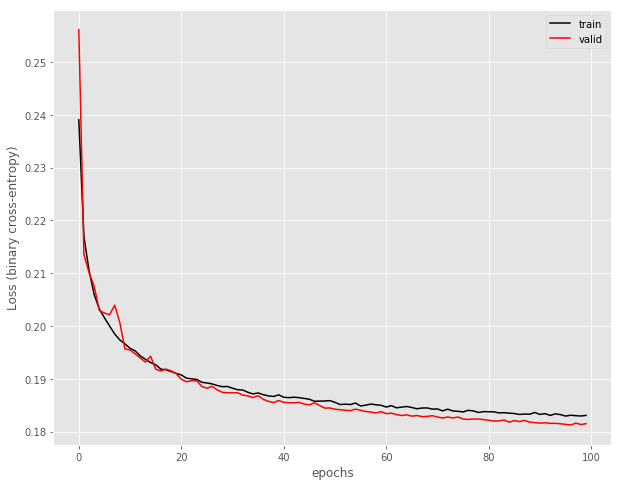

In [73]:
plt.plot(history.history['loss'], 'k-', label='train');
plt.plot(history.history['val_loss'], 'r-', label='valid');
plt.xlabel('epochs');
plt.ylabel('Loss (binary cross-entropy)')
#plt.yscale('log');
plt.legend(loc='best');

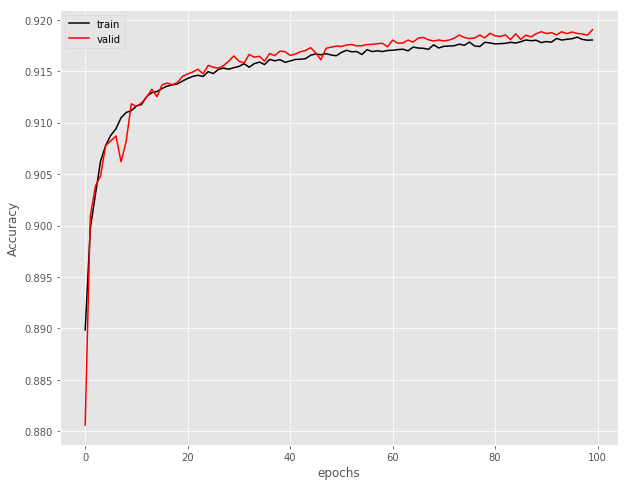

In [74]:
plt.plot(history.history['acc'], 'k-', label='train');
plt.plot(history.history['val_acc'], 'r-', label='valid');
plt.xlabel('epochs');
plt.ylabel('Accuracy')
#plt.yscale('log');
plt.legend(loc='best');

In [75]:
this_run = np.mean(history.history['val_loss'][-50:])
print('This run: %.5f' % this_run)

This run: 0.18262


In [76]:
if this_run < best_val_loss:
    print('New Best Model Found!\n')
    best_val_loss = this_run
    train_loss_of_best = np.mean(history.history['loss'][-50:])
    best_params = get_params()
print('Best validation loss so far: %.5f' % best_val_loss)
print('Training loss of same model: %.5f' % train_loss_of_best)
print('Best hyperparameters found so far:')

New Best Model Found!

Best validation loss so far: 0.18262
Training loss of same model: 0.18407
Best hyperparameters found so far:


In [77]:
pprint(best_params)

{'BATCH_SIZE': 1024,
 'BETA_1': 0.9,
 'BETA_2': 0.999,
 'DECAY': 0.01,
 'DROPOUT': 0,
 'EPOCHS': 100,
 'EPSILON': 1e-08,
 'ETA': 0.1,
 'NODES_PER_LAYER': [20,
                     20,
                     20,
                     20,
                     20,
                     20,
                     20,
                     20,
                     20,
                     20,
                     20,
                     20,
                     20,
                     20,
                     20,
                     20,
                     2]}


# Check Performance Against Test Set

In [78]:
preds = model.predict(X_test)

In [79]:
print(preds[:10])
print(y_test[:10])

[[  9.52188253e-01   4.78117056e-02]
 [  9.79239702e-01   2.07602587e-02]
 [  9.98868883e-01   1.13113446e-03]
 [  9.83262658e-01   1.67373810e-02]
 [  3.18006098e-01   6.81993961e-01]
 [  9.99871016e-01   1.28950662e-04]
 [  7.23227084e-01   2.76772946e-01]
 [  9.89556253e-01   1.04437359e-02]
 [  6.93730533e-01   3.06269467e-01]
 [  9.98389006e-01   1.61099236e-03]]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [80]:
def preds2probs(preds):
    return [pred[1] for pred in preds]

In [81]:
pred_probs = preds2probs(preds)
pred_probs[:10]

[0.047811706,
 0.020760259,
 0.0011311345,
 0.016737381,
 0.68199396,
 0.00012895066,
 0.27677295,
 0.010443736,
 0.30626947,
 0.0016109924]

In [82]:
def binarize(preds):
    return [[round(x) for x in p] for p in preds]

def one_cold(one_hot_matrix):
    # [[0, 1], [0, 1], [1, 0]] -> [1, 1, 0]
    return [argmax(vector) for vector in one_hot_matrix]

In [87]:
preds = one_cold(binarize(preds))
y_test = one_cold((y_test))

print(preds[:10])
print(y_test[:10])

[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [88]:
def print_cm(tp, tn, fp, fn):
    print('Confusion Matrix:')
    print('         Predicted:')
    print('         \t1\t\t0')
    print('Actual: 1\t%d\t\t%d' %(tp, fn))
    print('        0\t%d\t\t%d' %(fp, tn))

In [89]:
pred = np.array([0, 0, 1, 1])
target = np.array([0, 1, 0, 1])
print('true pos: ', (pred & target))
print('true neg: ', 1 * (np.logical_not(pred) & np.logical_not(target)))
print('false pos:', 1 * (pred & np.logical_not(target)))
print('false neg:', 1 * (np.logical_not(pred) & target))

true pos:  [0 0 0 1]
true neg:  [1 0 0 0]
false pos: [0 0 1 0]
false neg: [0 1 0 0]


In [90]:
def make_confusion_matrix(targets, pred_probs, threshold, verbose=True):
    targets = np.array(targets)
    pred_probs = np.array(pred_probs)
    preds = 1 * (pred_probs >= threshold)
    
    #preds_binary = binarize(preds)
    tp = sum(preds & targets)
    tn = sum(np.logical_not(preds) & np.logical_not(targets))
    fp = sum(preds & np.logical_not(targets))
    fn = sum(np.logical_not(preds) & targets)
    
    if verbose:
        print_cm(tp, tn, fp, fn)

    return {'tp': tp, 'fp': fp,'tn': tn, 'fn': fn}

In [91]:
print(y_test[:10])
print(pred_probs[:10])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0.047811706, 0.020760259, 0.0011311345, 0.016737381, 0.68199396, 0.00012895066, 0.27677295, 0.010443736, 0.30626947, 0.0016109924]


In [92]:
cm = make_confusion_matrix(y_test, pred_probs, 0.5)

Confusion Matrix:
         Predicted:
         	1		0
Actual: 1	14996		5791
        0	4799		106133


In [93]:
def get_metrics(cm):
    accuracy  = ((cm['tp'] + cm['tn']) /
                 (cm['tp'] + cm['tn'] + cm['fp'] + cm['fn']))
    precision = cm['tp'] / (cm['tp'] + cm['fp'])
    recall    = cm['tp'] / (cm['tp'] + cm['fn'])
    F         = 2 * precision * recall / (precision + recall)

    print('Accuracy: ', accuracy)
    print('Precision:', precision)
    print('Recall:   ', recall)
    print('F1:       ', F)

In [94]:
metrics = get_metrics(cm)

Accuracy:  0.919601576082
Precision: 0.757565041677
Recall:    0.721412421225
F1:        0.73904686807


In [95]:
def get_auc(target, preds):
    fpr, tpr, _ = roc_curve(target, preds)
    mod_auc = auc(fpr, tpr)
    print('AUC:      ', mod_auc)

    return { 'fpr': fpr, 'tpr': tpr, 'auc': mod_auc }

In [96]:
def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr, 'k')
    plt.plot([0, 1], [0, 1], 'r')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('ROC Curve')
    plt.show()

In [97]:
auc_metrics = get_auc(y_test, pred_probs)
auc_metrics['fpr']

AUC:       0.960709254746


array([  0.00000000e+00,   0.00000000e+00,   9.01453142e-06, ...,
         9.78707677e-01,   9.78725706e-01,   1.00000000e+00])

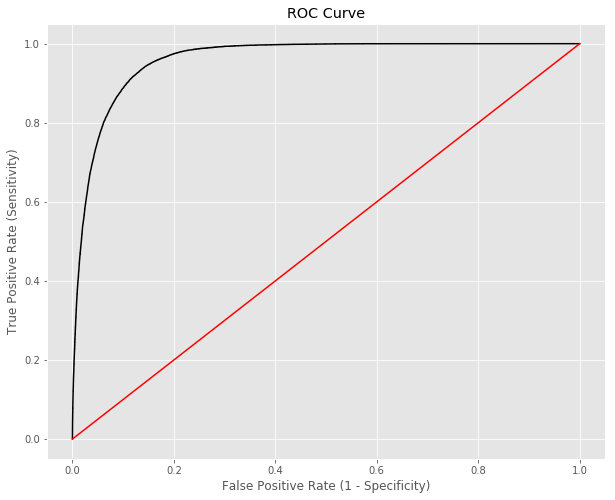

In [98]:
plot_roc(auc_metrics['fpr'], auc_metrics['tpr'])